# Steps to creating the initial iterations of HABs tracker map

## <span style="color:royal blue">1) Install and import all packages/modules </span>
   #### <span style="color:royal blue"> Although all packages may not be used, please download all to avoid any issues  </span>

#### Please install these packages into your environment: <span style="color:red"> numpy, pandas, netCDF4, matplotlib, folium, xarray, cartopy, metpy, cmocean, pyproj</span>


### Basic packages

In [1]:
import numpy as np
import pandas as pd
import netCDF4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium import plugins
from folium.plugins import HeatMap
import xarray as xr
import datetime
import math

### Cartopy and metpy for point interpolation

In [2]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from metpy.cbook import get_test_data
from metpy.interpolate import (interpolate_to_grid, remove_nan_observations,
                               remove_repeat_coordinates)

### Shapely, geopandas, and geoplot for creating x,y point values

In [3]:
import shapely
import geopandas as gpd
from shapely.geometry import Point
import geoplot as gplt
import geoplot.crs as gcrs

### cmocean

In [6]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch
from matplotlib import cm
from cmocean import cm as cmo
import cmocean
import sys
import os
from cartopy.util import add_cyclic_point

### pyproj for projection and tri for the triangular mesh grid

In [4]:
import pyproj
import matplotlib.tri as tri

## <span style="color:royal blue">2) Import datasets </span>

In [5]:
habs_net = Dataset("HABS.nc", mode='r')
topology_net = Dataset("fvcom_erie.nc", mode='r')

## <span style="color:royal blue">3a) Clean HABs data and create filtered dataframe </span>
We are only concerned about the latitude, longitude, and concentration data for each node so we will create a dataframe that holds this data for each node during the first timestamp and the at the first zlay layer (surface level)

In [36]:
lat = habs_net.variables['lat'][:]
lon = habs_net.variables['lon'][:]

In [37]:
lon = np.where(lon > 180., lon-360., lon)

In [38]:
#taking a slice of the concentration variables for first time, first zlay layer, for all nodes
concslice = habs_net.variables['conc'][0][0][:]

In [39]:
clean_habs = pd.DataFrame()
clean_habs['lat']=lat
clean_habs['lon']=lon
clean_habs['conc']=concslice

## <span style="color:royal blue">3b) Export dataframe for record keeping  - OPTIONAL</span>
Each HABs file will have its own csv with the first timestamp in the file as the filename

In [54]:
#Convert timestamp into a suitable format 
listed_habs = np.ascontiguousarray(habs_net.variables['timestamp'][:,:23])
#print(listed_habs)
s23 = listed_habs.view('S23').ravel() # squash the char array into strings
#print(s23)
dth = np.array([pd.Timestamp(t.decode('UTF-8')).round('60min').to_pydatetime().replace(tzinfo=None) for t in s23])

In [41]:
#unique names for each habs file - first timestamp in file
file_timestamp = dth[0].isoformat()
filename = "HABS.{}.csv".format(file_timestamp)

In [42]:
# Exporting each habs files to CSV for records 
clean_habs.to_csv(filename)

# <span style="color:royal blue">4) First iteration: folium maps </span>

### <span style="color:royal blue"> a) Folium heatmap that plots only concentrations above 0 </span>

<ol>
  <span style="color:royal blue"><li>Folium heatmap that plots only concentrations above 0</span></li>
</ol>

In [44]:
#Only map concentrations larger than zero
conc_vals = clean_habs.loc[clean_habs['conc'] > 0] 

In [45]:
map_heat = folium.Map(location=[41.6, -82.6],
                    zoom_start = 8) 

In [46]:
heat_data = [[row['lat'],row['lon']] for index, row in conc_vals.iterrows()]
HeatMap(heat_data).add_to(map_heat)

In [48]:
map_heat

- <span style="color: Green">Pros: </span>This map can be interactive and is a very visually appealing and easy to understand
- <span style="color: Red">Cons: </span>Instead of visualizing the HABs concentrations, this map creates the heatmap color gradient based on how many points are within one area. Since this map is only plotting positive concetrations, even if all of those positive concentrations are very low, a bunch of data points in one area will show up as a dark spot on the heat map. This does not correctly depict the intensity of the HABs concentration. 

### <span style="color:royal blue"> b) Folium markermap that plots concentrations above 0 in different color bins depending on conc value</span>

In [ ]:
#Breaking up concentrations into different color bins
clean_habs['marker_color'] = pd.cut(clean_habs['conc'], bins=6, 
                              labels=['purple','blue','green', 'yellow', 'orange', 'red'])

In [ ]:
marker_map = folium.Map(location=[41.6, -82.6],
            zoom_start=8.2
          )

In [ ]:
for index, row in clean_habs.iterrows():
    folium.CircleMarker([row['lat'], row['lon']],
                        popup='HABs concentration: '+str(row['conc'])[:5]+" microgram/L cyanobacterial chlorophyll",
                        radius= 3.5,
                        fill=True,
                        fill_color =row['marker_color'],
                        color=row['marker_color']).add_to(marker_map)

In [ ]:
marker_map4

- <span style="color: Green">Pros: </span>This map is great for individually visualizing each node within the lake and displaying its concentration with the hover tool as well as the color coding for the magnitude of the concentration. 
- <span style="color: Red">Cons: </span> This map does not display data for areas that have a HABs concentration of 0 and makes it seem like the map is missing information or does not have data for those areas even though the data is available. Additionally, this map does not create a continuous image of the HABs concentrations or show how they change over time.

## <span style="color:royal blue">5) Second iteration: Geopandas dataframe and KDE plot</span>

### <span style="color:royal blue"> a) Create Geopandas dataframe with projected points</span>

In [57]:
geometry = [Point(xy) for xy in zip(clean_habs['lon'], clean_habs['lat'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(clean_habs, crs=crs, geometry=geometry)

/anaconda3/envs/habsvirtual/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### <span style="color:royal blue">b) Scale geopandas data</span>

In [58]:
simulated_gdf = []

In [59]:
for x in gdf.to_dict('records'):
    factor = math.floor(x['conc']) + 1 * 50  #can do X3 to make it bigger as values get larger
    for i in range(factor):
        simulated_gdf.append(x)

In [61]:
scaled_df = pd.DataFrame(simulated_gdf)

In [62]:
geometry_scaled = [Point(xy) for xy in zip(scaled_df['lon'], scaled_df['lat'])]
crs2 = {'init': 'epsg:4326'}
gdf_scaled = gpd.GeoDataFrame(scaled_df, crs=crs, geometry=geometry_scaled)

We are scaling the data here so that the magnitude of each point is displayed rather than showing the density of the amount of points in one area. 

### <span style="color:royal blue">c) Create KDE Plot</span>

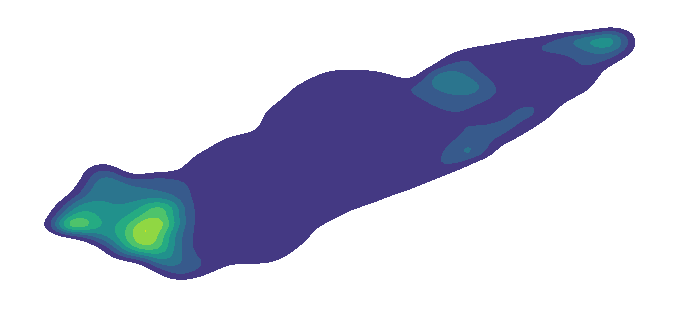

In [66]:
ax2 = gplt.kdeplot(gdf_scaled, cmap='viridis', projection=gcrs.WebMercator(), figsize=(12,12), shade = True)

- <span style="color: Green">Pros: </span>This KDE plot is a great step to display the HABs infromation in a somewhat continuous way. This map does a good job at outlining problem areas and giving a loose representation of the HABs concetrations
- <span style="color: Red">Cons: </span>This map could be more accurate and percise, the hot spots are clearly displayed however, they are loosely represented and it is hard to see how accruate these color distinctions are.

## <span style="color:royal blue">6) Third iteration: Linear interpolation map with metpy and cartopy </span>


changing lat and lon variables into arrays and projecting the points

In [75]:
lon_array = clean_habs.lon.to_numpy()
lat_array = clean_habs.lat.to_numpy()
to_proj = ccrs.AlbersEqualArea(central_longitude=lon_array.mean(), central_latitude=lat_array.mean())
xp, yp, _ = to_proj.transform_points(ccrs.Geodetic(), lon, lat).T

Interpolating points to create a grid

In [76]:
x_masked, y_masked, t = remove_nan_observations(xp, yp, clean_habs['conc'].values)
tempx, tempy, temp = interpolate_to_grid(x_masked, y_masked, t, interp_type='linear',
                                         minimum_neighbors=2, search_radius=4000, hres=1000)

temp = np.ma.masked_where(np.isnan(temp), temp)

set color values

In [99]:
levels = list(range(-10, 30, 1))
cmap = plt.get_cmap('Paired')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

Plot contour map

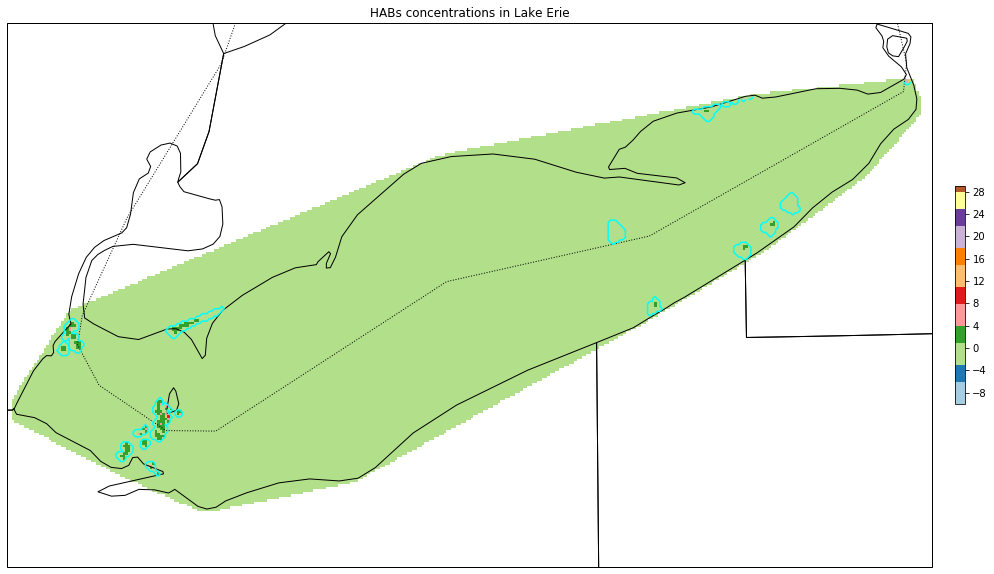

In [100]:
fig = plt.figure(figsize=(20, 10))
view = fig.add_subplot(1, 1, 1, projection=to_proj)
view.set_extent([-125, -75, 25, 55])
view.add_feature(cfeature.STATES.with_scale('50m'))
view.add_feature(cfeature.OCEAN)
view.add_feature(cfeature.COASTLINE.with_scale('50m'))
view.add_feature(cfeature.BORDERS, linestyle=':')

cs = view.contour(tempx, tempy, temp, colors='aqua', levels=list(range(990, 1034, 4)))
view.clabel(cs, inline=1, fontsize=12, fmt='%i')
view.set_extent([lon_array.min(), lon_array.max(), lat_array.min()-0.2, lat_array.max()+0.2])

mmb = view.pcolormesh(tempx, tempy, temp, cmap=cmap, norm=norm)
fig.colorbar(mmb, shrink=.4, pad=0.02, boundaries=levels)

# view.barbs(windgridx, windgridy, uwind, vwind, alpha=.4, length=5)

view.set_title('HABs concentrations in Lake Erie')

plt.show()

- <span style="color: Green">Pros: </span>Accurately displays a map of Lake Erie and highlights all of the problem areas where concentrations are higher. Contour lines actually outline the areas that are shown to have higher concentration and areas with high concentration are colored with their associated concetration color.
- <span style="color: Red">Cons: </span>This map is not as easy to understand and may confuse viewers. Since the coloring extends beyong the Lake the information may be misunderstood and the small color spots are not easy to interpret. 

## <span style="color:royal blue">7) Triangular Mesh grid </span>


In [87]:
EPSG3857 = pyproj.Proj(init='EPSG:3857')

/anaconda3/envs/habsvirtual/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [125]:
# topology (via FVCOM file, not included in habtracker)
nv = topology_net.variables['nv'][:].T
nv = nv - 1
# nodes
lon = topology_net.variables['lon'][:]
lon = np.where(lon > 180., lon-360., lon)
lat = topology_net.variables['lat'][:]
# elements
lonc = topology_net.variables['lonc'][:]
lonc = np.where(lonc > 180., lonc-360., lonc)
latc = topology_net.variables['latc'][:]
# project to EPSG:3857 for map
lo,la   = EPSG3857(lon,lat)
loc,lac = EPSG3857(lonc,latc)

con_matrix shows the connectivity matrix which are all the triangles - each row references three nodes that make up the triangle

In [126]:
con_matrix = topology_net.variables['nv'][:].T
con_matrix = (con_matrix.data) - 1

In [127]:
x,y = lon_array,lat_array

In [128]:
#All triangles on grid
tri_mesh_grid = tri.Triangulation(x, y, triangles=con_matrix)

In [130]:
d = clean_habs['conc'] + 1 

In [132]:
d = d*d

https://stackoverflow.com/questions/41596386/tripcolor-using-rgb-values-for-each-vertex

Text(0.5, 1.0, 'triplot of connectivity matrix')

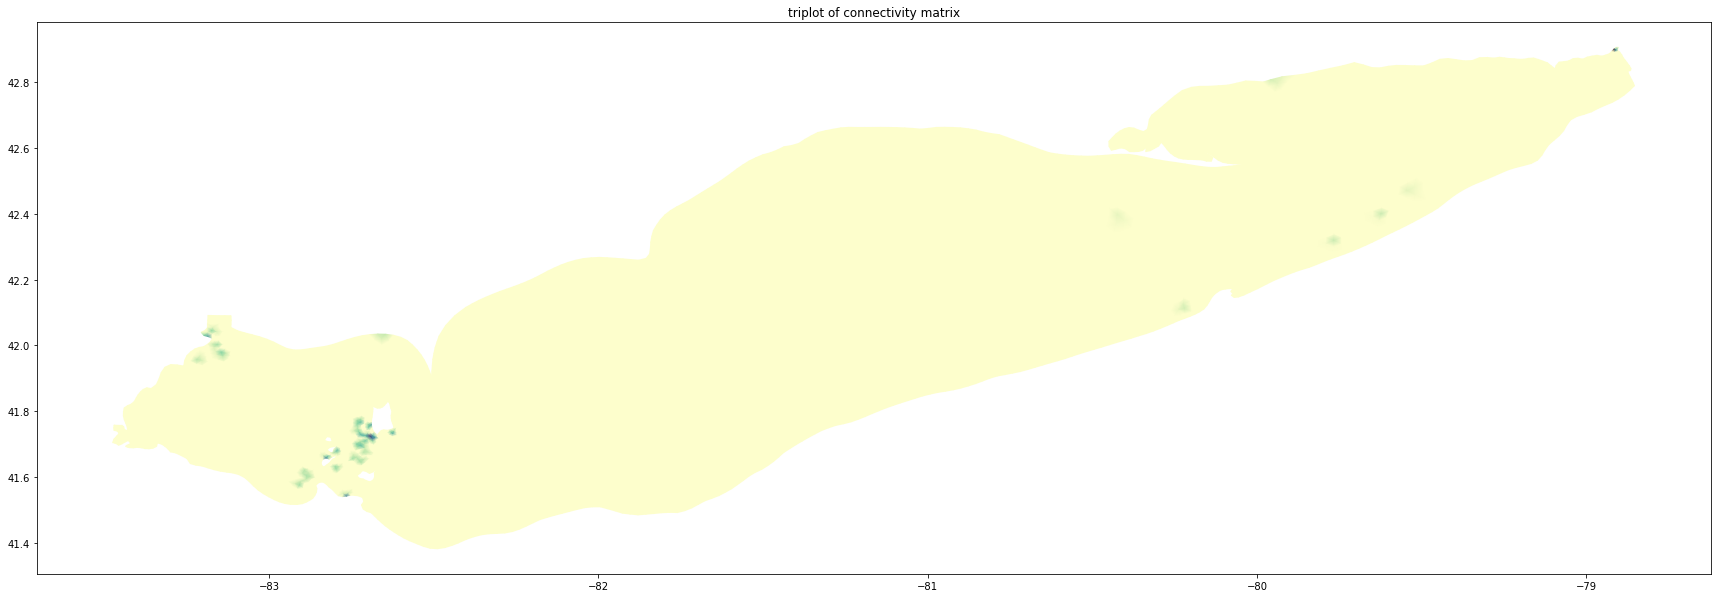

In [135]:
fig, ax = plt.subplots(figsize=(30,30))

ax.set_aspect('equal')


 
cb = ax.tripcolor(x, y, con_matrix, clean_habs['conc'], alpha=1, cmap=cmocean.cm.deep, vmin=0, vmax=20, shading='gouraud')
#fig.colorbar(cb,shrink=.1, pad=0.02, boundaries=levels)
ax.set_title('Lake Erie HABs Tracker')



- <span style="color: Green">Pros: </span>This map accurately displays the outline of Lake Erie and highlights the problem areas by color. The triangular mesh grid allowed the data points to be projected onto the map in a continuous fashion. Using the tripcolor function also allowed the datapoints to be interpolated so that there is no empty areas without data/color. 
- <span style="color: Red">Cons: </span>This map needs an underlying map of Lake Erie and the surrounding area and also does not have any interactive features or ways to show the change in HABs concentrations over time